# Access to Swisstopo Lidar Data

This notebook shows and explain how to get the low resolution Lidar data from Swisstopo and how to process them.

Most example are taken or inspired from [laspy documentation](https://laspy.readthedocs.io/en/latest/index.html).

In [1]:
# These libraries are needed for the notebook
!pip install numpy          # must have
!pip install pandas         # must have
!pip install laspy          # must have

!pip install matplotlib     # nice to have

## Get the data

Go to [this](https://www.swisstopo.admin.ch/fr/geodata/height/surface3d.html#technische_details) website, to the 'swissSURFACE3D - Accès aux géodonnées' part and select the area of data that you want. 

For this example we select by commune and selct the commune of Fribourg (FR). As option, we keep the format LIDAR (ZIP), coordonates system MN95 (default) and the actual state. 
4 links are made available to download. For the sake of the example, we only download the first one here: 'swisssurface3d_2019_2576-1183_2056_5728.las.zip'. Click on 'Download'.

You now have a file 'swisssurface3d_2019_2576-1183_2056_5728.las.zip' locally of around 130MB (or any other las.zip file). Make it accessible from your notebook.

In [2]:
!wget https://data.geo.admin.ch/ch.swisstopo.swisssurface3d/swisssurface3d_2019_2576-1183/swisssurface3d_2019_2576-1183_2056_5728.las.zip

--2022-09-17 10:37:02--  https://data.geo.admin.ch/ch.swisstopo.swisssurface3d/swisssurface3d_2019_2576-1183/swisssurface3d_2019_2576-1183_2056_5728.las.zip
Resolving data.geo.admin.ch (data.geo.admin.ch)... 13.224.103.102, 13.224.103.25, 13.224.103.20, ...
Connecting to data.geo.admin.ch (data.geo.admin.ch)|13.224.103.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134309729 (128M) [application/vnd.laszip]
Saving to: ‘swisssurface3d_2019_2576-1183_2056_5728.las.zip’

swisssurface3d_2019 100%[===================>] 128.09M  5.91MB/s    in 35s     

2022-09-17 10:37:38 (3.65 MB/s) - ‘swisssurface3d_2019_2576-1183_2056_5728.las.zip’ saved [134309729/134309729]



## Process the data

In [3]:
# TODO: adapt this path to access the downloaded data from your notebook
SOURCE_LIDAR_ZIP = 'swisssurface3d_2019_2576-1183_2056_5728.las.zip'
TARGET_LIDAR_FOLDER = 'fribourg_part_1' 

### Unzip the file and get its path

In [4]:
import zipfile

with zipfile.ZipFile(SOURCE_LIDAR_ZIP, 'r') as zip_ref:
    zip_ref.extractall(TARGET_LIDAR_FOLDER)

In [5]:
import os
las_path = os.path.join(TARGET_LIDAR_FOLDER, os.listdir(TARGET_LIDAR_FOLDER)[0])
las_path

'fribourg_part_1/2576_1183.las'

### Open Lidar data
The file is stored in [las format](https://laspy.readthedocs.io/en/latest/intro.html) which is a public standard format for exchanging 3D point data. There are different python librairies to process this type of data. Here we will use [laspy](https://pypi.org/project/laspy/).

In [6]:
import laspy as lp
import numpy as np

### Get metadata information

In [7]:
#  Read and show metadate about point cloud
with lp.open(las_path) as f:
    # Get metadata information
    print(f"Point format:             {f.header.point_format}")
    print(f"Number of points:         {f.header.point_count}")
    print(f"Variable length record:   {f.header.vlrs}\n")
    
    # Read the point cloud data
    las = f.read()
    print(f"Las file:                 {las}")
    point_format = las.point_format
    print(f"Dimensions:               {list(point_format.dimension_names)}\n")
    
    # Offset and scaling for projections (discussed later)
    print(f"Points offset:            {f.header.offset}")
    print(f"Points scaling:           {f.header.scale}")

Point format:             <PointFormat(1, 0 bytes of extra dims)>
Number of points:         10745958
Variable length record:   []

Las file:                 <LasData(1.2, point fmt: <PointFormat(1, 0 bytes of extra dims)>, 10745958 points, 0 vlrs)>
Dimensions:               ['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'synthetic', 'key_point', 'withheld', 'scan_angle_rank', 'user_data', 'point_source_id', 'gps_time']

Points offset:            [2576000. 1183000.       0.]
Points scaling:           [0.01 0.01 0.01]


### Process Lidar Data

In [8]:
import pandas as pd

In [9]:
las = lp.read(las_path)

In [10]:
# Get pandas dataset of the point cloud coordinates and class
df = pd.DataFrame({'X': las.X, 'Y': las.Y, 'Z':las.Z, 'Class': np.array(las.classification)})
df.head()

,X,Y,Z,Class
0,0,36772,69740,1
1,0,43017,69839,6
2,0,44362,69838,6
3,0,45557,70020,6
4,0,51015,69145,2


From there, you can do anything that you can usually do in pandas. You can modify the dataset to add other columns from the point cloud.

### Plot Lidar data

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

In [12]:
# Subsample (to have less points)
print(f'Previous size: {df.shape}')
df = df.sample(frac=0.50, replace=False, random_state=1)

# Keep a smaller region
df = df[df['X'] > np.mean(df['X'])]
df = df[df['Y'] > np.mean(df['Y'])]
print(f'New size: {df.shape}')

Previous size: (10745958, 4)
New size: (1234704, 4)


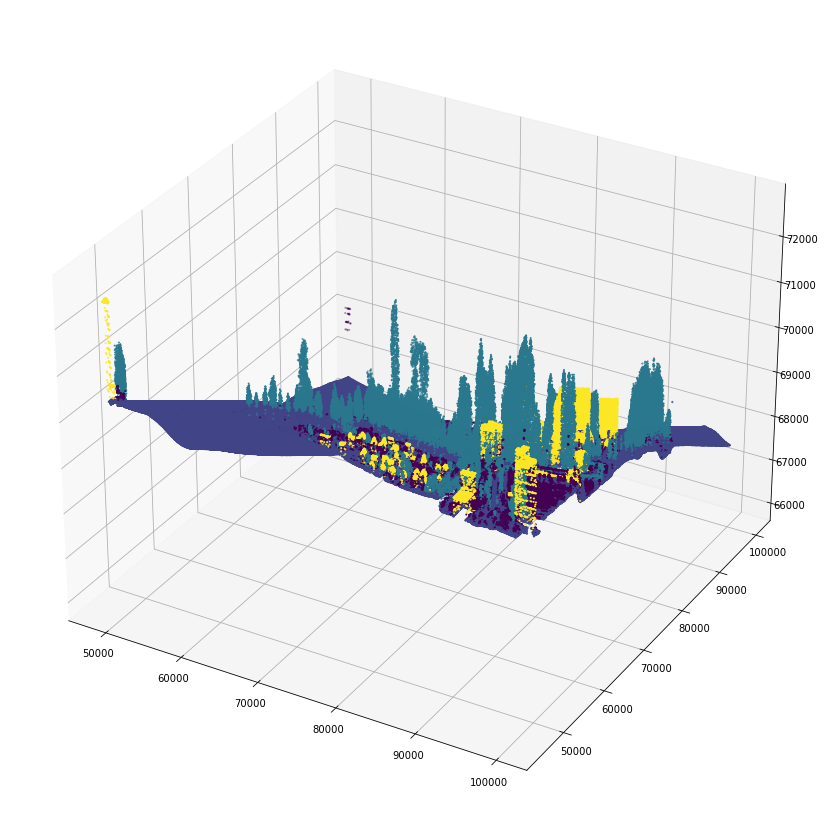

In [13]:
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection='3d')
ax.scatter3D(df['X'], df['Y'], df['Z'], c =  df['Class'], cmap='viridis', s=1);

### Reproject to another Reference Coordinate System

Unfortunatelly with these data, the variable length record which should contain the reference coordinate system (see above in metadata part) is empty. 

Based on the additonal documentation of swissSURFACE3D, we know that every downloaded tiles names contain an id which corresponds to the kilometric coordinates in the reference system [MN95] (https://www.swisstopo.admin.ch/fr/connaissances-faits/mensuration-geodesie/cadres-de-reference/local/mn95.html#234_1607609199106) in the south-west angle.

Hence our `swisssurface3d_2019_2576-1183_2056_5728.las` would be the tile recorded in 2019 at the coordinate (2576, 1183) as can be checked below:

In [14]:
#  Read and show metadate about point cloud
with lp.open(las_path) as f:
    # Offset and scaling for projections ()
    print(f"Points offset:            {f.header.offset}")
    print(f"Points scaling:           {f.header.scale}")
    x_offset, y_offset, z_offset = f.header.offset
    x_scale, y_scale, z_scale = f.header.scale

Points offset:            [2576000. 1183000.       0.]
Points scaling:           [0.01 0.01 0.01]


To reconstruct the original point cloud in MN95 coordinates in the system CH1903+, the coordinates are calculated using the following formula(s): \
x = (x_int * x_scale) + x_offset \
y = (y_int * y_scale) + y_offset \
z = (z_int * z_scale) + z_offset

In [15]:
df['X'] = df['X'] * x_scale + x_offset
df['Y'] = df['Y'] * y_scale + y_offset
df['Z'] = df['Z'] * z_scale + z_offset

In [16]:
df.rename(columns = {'X': 'Easting', 'Y': 'Northing', 'Z': 'Elevation'}, inplace = True)

In [17]:
df.head() # in CH1903+ coordinates

,Easting,Northing,Elevation,Class
8412443,2576968.53,1183640.37,709.20,3
3009217,2576699.95,1183672.00,688.43,2
2709124,2576956.19,1183814.63,687.23,2
8123143,2576907.43,1183924.63,679.72,2
2916783,2576514.09,1183830.80,667.58,2


To reproject in any other coordinate reference system, more complicated formulas are required. They can be found online and applied to the points.